author : kraemer valentin 

date : 12 nov 2023

desc :  tentative de résolution 1D du pb d'advection diffusion avec DD Robin 

cours : PFE - A. Arnould, C. Japhet, P.Omnes

#  Version 1 -  Méthode de décomposition de domaine avec Robin 
# Schéma cell-centered VF décentré hybride pour d'advection 

## Problème d'advection diffusion stationnaire :

On se pose le problème 1D suivant : 

Soient $\Omega = ]x_a, x_b[$ un ouvert borné de $\mathbb{R}$,   $\eta\geq 0,~ b \in \mathbb{R},~\nu>0, ~ \bar{f}\in L^2(\Omega),~ u_a, ~ u_b \in \mathbb{R}$, on cherche à résoudre le problème suivant: 

trouver $\bar{u}\in H^2(\Omega)$ tel que :

$$\eta u(x) + b u'(x) - \nu u''(x) = f, ~~ x\in \Omega$$

$$
u(x_a) = u_a, ~~
u(x_b) = u_b
$$

On se propose de résoudre ce problème avec l'algorithme de Schwarz avec conditions de Robin à l'interface. On y ajoutera par la suite une surcouche de parallélisation avec la bibliothèque mpi4py de python ainsi qu'un terme en temps. 

### Packages utiles

In [1]:
import numpy as np 
# sage 

## 0.0 Création préliminaire des objets utilisés

In [2]:
class mesh1D :
    """"
    Objet de maillage, schéma VF 1D
    Paramètres : x_a, x_b les bords de l'intervalles, N_intervals le nombre d'intervalles pour les T_i
    Perspective d'amélioration : disposition non uniforme des points 
    """
    def __init__(self, x_a, x_b, N_intervals):
        import numpy as np
        self.a = x_a 
        self.b = x_b 
        self.N_intervals = N_intervals
        X = np.linspace(x_a,x_b,N_intervals+1)
        
        # init du maillage primal
        T = np.empty((N_intervals, 2), dtype=np.double)
        T[:, 0] = X[0:-1]
        T[:, 1] = X[1:]
        self.T = T

        # init du maillage dual 
        D = np.empty((N_intervals+1,2))
        D[0,0]= x_a 
        D[-1, -1] = x_b
        H = (X[1:] -  X[0:-1] )
        Xmid = X[0:-1]+ H/2
        D[1:, 0] = Xmid
        D[:-1, 1] = Xmid
        self.D = D 

        self.supT = max(T[:,1] -T[:,0])
        self.supD = max(D[:,1] -D[:,0])
        self.H = H

class param_phy:
    """
    Objet de paramètres physiques liées au problèmes d'advection-diffusion 1D :
        eta*u + b*u' - nu*u'' = f
    Les paramètres entrant en jeux correspondent à : 
        - eta >= 0          : coefficient de reaction 
        - b real            : coefficient d'advection 
        - nu > 0            : coefficient de diffusion 
        - f in L^2          : terme source 
        - alpha_right > 0   : (facultatif) coefficient de Robin à droite 
        - alpha_left  > 0   : (facultatif) coefficient de Robin à gauche
    """
    def __init__(self, eta, nu, b, f, alpha_right= None, alpha_left= None): 
        self.eta = eta 
        self.nu = nu 
        self.b = b 
        self.f =f 
        self.alpha_right = alpha_right
        self.alpha_left = alpha_left

    def verif_params(self): 
        if self.eta <0:
            print('eta should be non negative')
            raise ValueError
        if self.nu <=0 :
            print('nu should be positive')
            raise ValueError
        if (self.alpha_left !=None) and (self.alpha_left<=0) :
            print('alpha_left should be positive')
            raise ValueError
        if (self.alpha_right!=None) and (self.alpha_right<=0):
            print('alpha_right should be positive')
            raise ValueError

In [120]:
class advec_diff:
    """
    Objet - résolution du problème d'advection diffusion 1D par méthode VF :
        eta*u + b*u' - nu*u'' = f

    Les paramètres en entrée sont les suivants : 
        - mesh              : (class mesh1D)    le maillage sur lequel on résoud le problème 
        - params            : (class param_phy) les paramètres physiques entrant en jeu dans le problème
        - value_right       : la valeur imposée à droite (condition de Robin ou de Dirichlet)
        - value_left        : la valeur imposée à gauche (condition de Robin ou de Dirichlet)
        - cond_right        : (default = 'Dirichlet') le type de condition à droite, si non Dirichlet -> Robin 
        - cond_left         : (default = 'Dirichlet') le type de condition à gauche, si non Dirichlet -> Robin 

    Les paramètres entrant en jeux dans params (class param_phy) sont  : 
        - eta >= 0          : coefficient de reaction 
        - b real            : coefficient d'advection 
        - nu > 0            : coefficient de diffusion 
        - f in L^2          : terme source 
        - alpha_right > 0   : (facultatif) coefficient de Robin à droite 
        - alpha_left  > 0   : (facultatif) coefficient de Robin à gauche

    Les données de maillages entrant en jeux sont (class mesh1D):
        Paramètres : x_a, x_b les bords de l'intervalles, N_intervals le nombre d'intervalles pour les T_i
    
    """
    def __init__(self, mesh, params, value_right, value_left, cond_right = 'Dirichlet', cond_left = 'Dirichlet') :
        self.params = params
        self.mesh = mesh
        self.value_right= value_right 
        self.value_left = value_left
        self.cond_left = cond_left
        self.cond_right = cond_right

    def verif_input(self) :
        if not isinstance(self.params, param_phy): 
            print('the param in advec_diff is not a param_phy class')
            raise TypeError
        self.params.verif_params()

        if not isinstance(self.mesh, mesh1D):
            print('the mesh is not a mesh1D class')
            raise TypeError    

        if (self.cond_left != 'Dirichlet' and self.params.alpha_left ==None) or (self.cond_right!='Dirichlet' and self.params.alpha_right==None) :
            print('bad initialization of Robin condition')
            raise AttributeError  
        
    def build_matrix(self):
        import scipy.sparse as sp
        bp = max(self.params.b, 0)
        bm = min(self.params.b, 0)
        n = self.mesh.N_intervals
        nu = self.params.nu
        eta = self.params.eta 
        h = self.mesh.supT # attention valable uniquement dans le cas du maillage regulier !!
        nu2h = 2*nu/h
        nu4h = 4*nu/h

        if self.cond_right == 'Dirichlet' :
            a_11 = eta *h  + ((nu2h-bm)**2)/(nu4h + bp-bm) +  nu2h+bp
            a_12 = - ((nu2h-bm)**2)/(nu4h+bp-bm)
            sm_1 = h*self.params.f(self.mesh.D[0,1])+ (nu2h+bp)*self.value_right
        else : 
            a_11 = eta*h + ((nu2h - bm)**2)/(nu4h+bp-bm) + ((nu2h + bp)*(self.params.alpha_right+bp))/(nu2h + bp + self.params.alpha_right)
            a_12 = ((nu2h - bm)**2)/(nu4h+bp-bm)
            sm_1 = h*self.params.f(self.mesh.D[0,1]) + (nu2h + bp)/(nu2h + bp + self.params.alpha_right) * self.value_right
        
        if self.cond_left == 'Dirichlet': 
            a_nn = eta*h + ((nu2h + bp)**2)/(nu4h+bp-bm) + nu2h-bm
            a_nnm = - ((nu2h-bm)**2)/(nu4h)
            sm_n = h*self.params.f(self.mesh.D[-1,0]) + (nu2h- bm)*self.value_left
        else : 
            a_nn = eta*h + ((nu2h + bp)**2)/(nu4h+bp-bm) + (nu2h-bm)*(self.params.alpha_left - bm)/(nu2h-bm + self.params.alpha_left)
            a_nnm = - ((nu2h+bp)**2)/(nu4h)
            sm_n = h*self.params.f(self.mesh.D[-1,0]) + (nu2h -bm)/(nu2h - bm + self.params.alpha_left) * self.value_left
        

        a_jjm = - ((nu2h+ bp)**2) / (nu4h + bp-bm)
        a_jj  = eta*h + ((nu2h - bm)**2  + (nu2h + bp)**2 ) / (nu4h +bp - bm)
        a_jjp = - ((nu2h - bm)**2) / (nu4h + bp-bm)


        # Matrix assembly
        A = sp.csc_matrix(sp.diags([a_jjm*np.ones(n-1, dtype=np.double),a_jj*np.ones(n, dtype=np.double),a_jjp*np.ones(n-1, dtype=np.double)], [-1,0,1], shape=(n,n)))
        A[0,0]=  a_11
        A[0,1] = a_12
        A[-1,-1]=  a_nn
        A[-1, -2]=  a_nnm


        # second member assembly
        # print(f'n_intervals = {n},taille de S = {n+1},  taille de D = {np.size(self.mesh.D[1:, 0])}')

        SM = np.empty((n), dtype=np.double)
        SM[1:-1] = self.params.f(self.mesh.D[2:-1, 0])
        SM[0]= sm_1
        SM[-1]= sm_n

        return (A, SM)


    def solve(self) :
        from scipy.sparse.linalg import spsolve
        (A,B) = self.build_matrix()
        return spsolve(A, B)

## 1.0 Phase de test

Après avoir programmé ces différents objets, on se propose de les tester pour évaluer la méthode et le code. 

Commençons par définir les paramètres numériques du problème.

### Choix du maillage 

Amélioration : lire les données numériques dans un fichier prévu à cet effet sous forme de dictionnaire ?

In [4]:
x_a = 0.1                   # eviter les valeurs risquant les simplification ex : sin(0) = 0..
x_b = 4.1 
N_intervals = 100

mesh = mesh1D(x_a, x_b, N_intervals)

Définissons ensuite les données physiques du problème. 

### Choix des coefficients du problèmes

Amélioration : lire les données physiques dans un fichier prévu à cet effet (sous forme de dictionnaire ?) 

In [5]:
# coefficient de reaction, diffusion, advection
(eta, nu, b) = (1., 0.8, 7)
cond_right   = 'Dirichlet'          # ou cond_right = 'Robin'
cond_left    = 'Dirichlet'          # ou cond_left  = 'Robin'

# coefficient de Robin 
alpha_right = 2.   if (cond_right != 'Dirichlet')  else None
alpha_left  = 1.2  if (cond_left  != 'Dirichlet')  else None

### Choix de la solution théorique et du terme source correspondant:

On se donne une fonction u quelconque de $H^2(\Omega)$, prenons par exemple celle-ci :

In [6]:
def u_theo(x) : 
    return np.sin(2*x)+ 3*x+2 

#### Méthode 1 : utilisation de sage pour trouver le terme source 

En exécutant la commande **sage** suivante, on trouve la forme du terme source à implémenter pour obtenir u, solution exacte du problème d'advection-diffusion présenté précédemment. 

Amélioration : automatiser la sortie de sage pour la définition de la fonction f dans python par la suite.

In [7]:
%%bash
sage
u(x) =sin(2*x) + 3*x+2
eta = var('eta')
nu = var('nu')
b = var('b')
def f(u, x, eta, b, nu) : return eta*u(x) + b*derivative(u, x)(x) - nu * derivative(derivative(u,x),x)(x)
f(u, x, eta, b, nu)


┌────────────────────────────────────────────────────────────────────┐
│ SageMath version 9.5, Release Date: 2022-01-30                     │
│ Using Python 3.10.12. Type "help()" for help.                      │
└────────────────────────────────────────────────────────────────────┘
sage: sage: sage: sage: sage: sage: eta*(3*x + sin(2*x) + 2) + b*(2*cos(2*x) + 3) + 4*nu*sin(2*x)
sage: Exiting Sage (CPU time 0m0.45s, Wall time 0m0.48s).


Il ne reste plus qu'à copier-coller la solution de sage dans f pour obtenir le second membre souhaité. 

In [134]:
def func(x, eta, b, nu) :
    """"
    La fonction source
    """
    return eta*(3*x + np.sin(2*x) + 2) + b*(2*np.cos(2*x) + 3) + 4*nu*np.sin(2*x)

def f(x):
    return func(x, eta, b, nu)

#### Méthode 2 : Définir la fonction théorique ainsi que ses deux dérivées 

En définissant la fonction $u_{theo}$ et ses deux dérivées, on obtient un processus automatisant la génération de f. 

Desavantage : clairement plus gourmand en temps de calcul en terme d'évaluation. 

In [57]:
class u_theorique :
    """
    Solution théorique, ainsi que ses deux dérivées
    """
    def __init__(self) :
        pass 

    def u(self, x) :
        return np.sin(2*x)+ 3*x+2

    def du(self, x):
        return 2*np.cos(2*x)+3

    def ddu(self, x) :
        return -4*np.sin(2*x)

def func(u, x, eta, b, nu): 
    if not isinstance(u, u_theorique) : 
        print('error : u should be an u_theo objet')
        raise TypeError
    return eta * u.u(x) + b*u.du(x) - nu*u.ddu(x)
    
def f(x) :
    u = u_theorique()
    return func(u,x, eta, b, nu)

## 1.1 Implémentation de la phase de test

In [125]:
u_theo_obj = u_theorique()                  # objet de type u_theorique : contient la fonction theorique et ses deux derivees
u_theo = u_theo_obj.u                       # fonction u_theorique, n'est PAS un objet u_theorique mais uniquement la fonction !!

mesh = mesh1D(x_a, x_b, N_intervals)
param  = param_phy(eta, nu, b,f)

value_left = u_theo(x_a)
value_right = u_theo(x_b)

pb = advec_diff(mesh, params= param,value_left=value_left, value_right=value_right )
u_intern = pb.solve()

U= np.empty(N_intervals+2)
U[0]= value_left
U[1:-1]= u_intern
U[-1]= value_left

X = np.empty(N_intervals+2)
X[:-1] = mesh.D[:,0]
X[-1] = mesh.D[-1,1]

#### Affichage sortie 

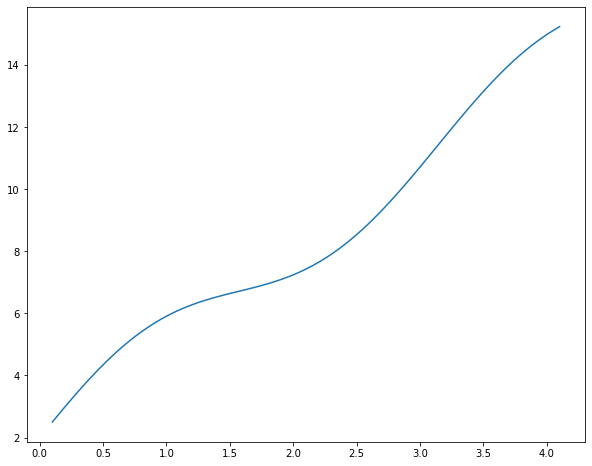

In [130]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize= (10,8))
#plt.plot(X,U)
plt.plot(X,u_theo(X))


In [132]:
X

array([0.1 , 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48,
       0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92,
       0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28, 1.32, 1.36,
       1.4 , 1.44, 1.48, 1.52, 1.56, 1.6 , 1.64, 1.68, 1.72, 1.76, 1.8 ,
       1.84, 1.88, 1.92, 1.96, 2.  , 2.04, 2.08, 2.12, 2.16, 2.2 , 2.24,
       2.28, 2.32, 2.36, 2.4 , 2.44, 2.48, 2.52, 2.56, 2.6 , 2.64, 2.68,
       2.72, 2.76, 2.8 , 2.84, 2.88, 2.92, 2.96, 3.  , 3.04, 3.08, 3.12,
       3.16, 3.2 , 3.24, 3.28, 3.32, 3.36, 3.4 , 3.44, 3.48, 3.52, 3.56,
       3.6 , 3.64, 3.68, 3.72, 3.76, 3.8 , 3.84, 3.88, 3.92, 3.96, 4.  ,
       4.04, 4.08, 4.1 ])